# CASO DE ESTUDIO 1
*Case of study 1*

## Data fetching

### Gastos

In [367]:
import pandas as pd

gastos = pd.read_csv('CasoMarketing-Gasto.csv')
gastos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Semana          48 non-null     int64 
 1   GastoAdwords    48 non-null     object
 2   GastoFacebook   48 non-null     object
 3   GastoInstagram  48 non-null     object
 4   GastoOrganico   48 non-null     object
dtypes: int64(1), object(4)
memory usage: 2.0+ KB


| **Column name** | **Feature description** |
|----------------:| :--------------------- |
| *Semana*        | Week of the data |
| *GastoAdwords*  | Google advertisement cost |
| *GastoFacebook* | Facebook avertisement cost |
| *GastoInstagram*| Intsgram advertisement cost |
| *GastoOrganico* | Company's page cost |

The table must be cleaned and processed.

In [368]:
gastos.head()

,Semana,GastoAdwords,GastoFacebook,GastoInstagram,GastoOrganico
0,1,"$58,587.80","$13,166.12","$25,644.37",$0.00
1,2,"$67,295.35","$15,130.57","$25,603.19",$0.00
2,3,"$43,330.19","$14,983.00","$28,962.36",$0.00
3,4,"$60,818.66","$14,294.78","$29,601.45",$0.00
4,5,"$43,593.73","$18,685.01","$29,219.29",$0.00


In [369]:
gastos.drop('GastoOrganico', axis=1, inplace=True) # description specifies it is always 0

to_float = lambda x: float(x.replace('$', '').replace(',', '')) if isinstance(x, str) else x
gastos = gastos.applymap(to_float)

gastos.columns = [x.replace('Gasto', '') for x in gastos.columns] # For later convinience
gastos.rename(columns={'Adwords':'AdWords'}, inplace=True)
    
gastos.head()

,Semana,AdWords,Facebook,Instagram
0,1,58587.80,13166.12,25644.37
1,2,67295.35,15130.57,25603.19
2,3,43330.19,14983.00,28962.36
3,4,60818.66,14294.78,29601.45
4,5,43593.73,18685.01,29219.29


## Operaciones

In [370]:
ops = pd.read_csv('CasoMarketing-Operaciones.csv')
ops.head()

,Prospecto,Semana,Verificado,Oe,PrioridadProspecto,Canal
0,1,1,Si,6.0,Prioridad Alta,Organico
1,2,1,No,NaN,Prioridad Alta,Organico
2,3,1,Si,5.0,Prioridad Alta,Facebook
3,4,1,Si,14.0,Prioridad Alta,AdWords
4,5,1,Si,14.0,Prioridad Alta,AdWords


| **Column name** | **Feature description** |
|----------------:| :--------------------- |
| *Prospecto*     | Prospect ID |
| *Semana*        | Week of the data |
| *Verificado*    | Wether the prospect gave his/her credit card info. Main key to meassure success |
| *Oe*            | Days between account created and account verification |
| *PrioriddProspecto* | Prospect priority assigned by a ML algorithm |
| *Canal*         | Channel from where the client came from |

The table must be cleaned and processed.

In [371]:
ops.drop('Prospecto', axis=1, inplace=True) # Information about the identity of the prospect is irrelevant
ops['Oe'].fillna(-1, inplace=True)  # NA values would cause problems while graphing, they mean prosped was not verified
ops['Oe'] = ops['Oe'].apply(lambda x: int(x))

ops.sample(5)

,Semana,Verificado,Oe,PrioridadProspecto,Canal
4738,26,No,-1,Prioridad Media,AdWords
5941,31,Si,13,Prioridad Alta,Organico
5175,28,Si,7,Prioridad Alta,Organico
4935,27,Si,7,Prioridad Alta,Organico
1808,13,No,-1,Prioridad Media,Instagram


## Combine the data

In [372]:
data = ops.merge(gastos, on='Semana', how='inner')
data.sample(5)

,Semana,Verificado,Oe,PrioridadProspecto,Canal,AdWords,Facebook,Instagram
6031,31,No,-1,Prioridad Baja,Organico,108926.17,33790.19,66887.89
759,6,No,-1,Prioridad Baja,Instagram,58609.50,14708.50,32700.28
6531,33,No,-1,Prioridad Alta,Organico,97802.37,37681.19,65145.48
7322,36,Si,6,Prioridad Baja,Facebook,94392.20,33821.11,63647.88
6169,31,No,-1,Prioridad Baja,Facebook,108926.17,33790.19,66887.89


Simplify and process

In [373]:
data['Gasto'] = data.apply(lambda row: row[row['Canal']] if row['Canal'] in ['AdWords', 'Facebook', 'Instagram'] else 0, axis=1)
data.drop(['AdWords', 'Facebook', 'Instagram'], axis=1, inplace=True)
data.sample(5)

,Semana,Verificado,Oe,PrioridadProspecto,Canal,Gasto
10544,45,No,-1,Prioridad Media,Facebook,40108.95
2137,14,Si,13,Prioridad Alta,Organico,0.00
5752,30,Si,4,Prioridad Alta,AdWords,94430.35
883,7,No,-1,Prioridad Baja,Instagram,32865.13
5252,28,No,-1,Prioridad Media,Facebook,30487.31


# MAE

In [374]:
import seaborn as sea
import matplotlib.pyplot as plt

sea.set_theme()
sea.set_context('paper')

<Axes: xlabel='Semana'>

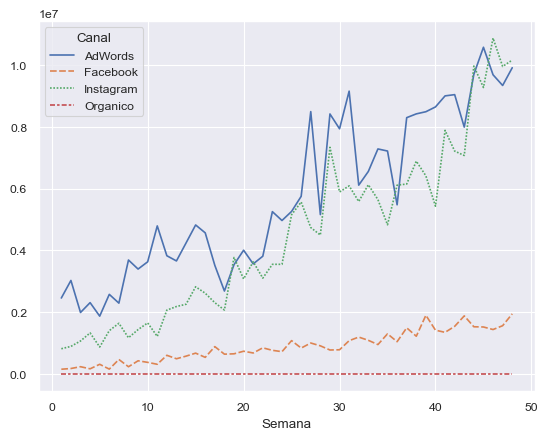

In [375]:
semana_canal = data.groupby(['Semana', 'Canal']).sum()['Gasto']
semana_canal = semana_canal.unstack(level=-1)
sea.lineplot(semana_canal)

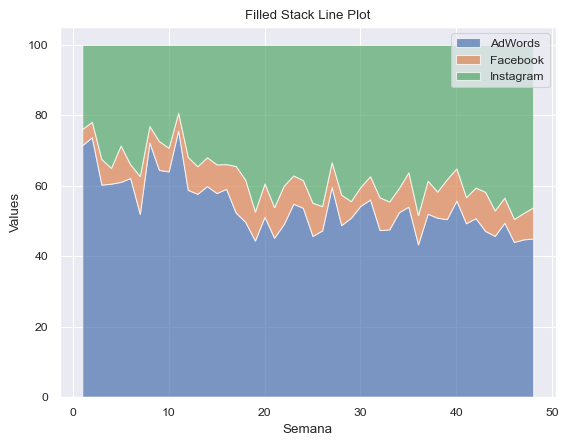

In [376]:
semana_canal['Total'] = semana_canal.sum(axis=1)
for col in list(semana_canal.columns):
    semana_canal[col] /= (semana_canal['Total']/100)
semana_canal.drop(['Organico', 'Total'], axis=1, inplace=True)

plt.stackplot(range(1, 49), semana_canal['AdWords'], semana_canal['Facebook'], semana_canal['Instagram'],
              labels=['AdWords','Facebook','Instagram'], alpha=0.7)
plt.legend(loc='upper right')
plt.title('Filled Stack Line Plot')
plt.xlabel('Semana')
plt.ylabel('Values')
plt.show()

<Axes: xlabel='Semana'>

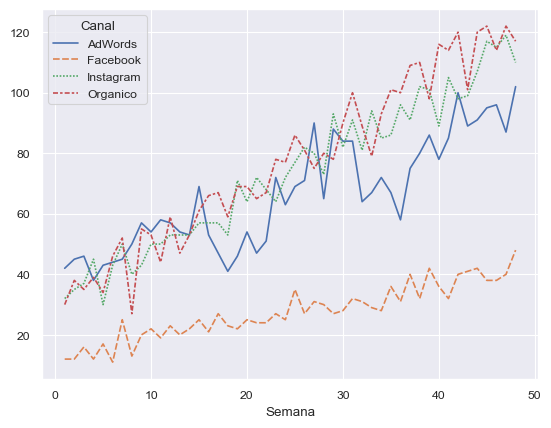

In [377]:
semana_canal = data.groupby(['Semana', 'Canal']).count()['Gasto']
semana_canal = semana_canal.unstack(level=-1)
sea.lineplot(semana_canal)

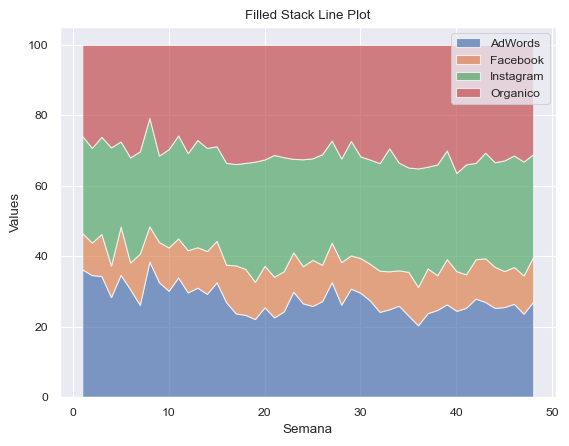

In [378]:
semana_canal['Total'] = semana_canal.sum(axis=1)
for col in list(semana_canal.columns):
    semana_canal[col] /= (semana_canal['Total']/100)
semana_canal.drop('Total', axis=1, inplace=True)

plt.stackplot(range(1, 49), semana_canal['AdWords'], semana_canal['Facebook'], semana_canal['Instagram'], semana_canal['Organico'],
              labels=['AdWords','Facebook','Instagram', 'Organico'], alpha=0.7)
plt.legend(loc='upper right')
plt.title('Filled Stack Line Plot')
plt.xlabel('Semana')
plt.ylabel('Values')
plt.show()